# PCA

In the real world, information is not spread out uniformally across all dimensions. Many features are almost constant (low variability) or are coorelated with one another. As a consequence, there is a strong possibility the original data actually lies within a lower dimensional subspace.

## A Baseline Introduction

PCA first identified the hyperplane that lies closest to the data, and then project the data onto it. So for example imagining a coffee mug. The plane that lies closest to the data might be the isometric view of the handle + everything else, as it captures the most information.

Take for instance this trivial _example_:

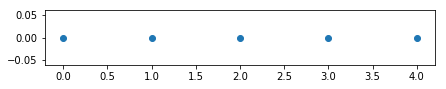

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 1))
X, y = list(range(5)), [0]*5
plt.scatter(X, y)

While the dataset is described in two dimensions, it can really just be described with just one dimension - and actually with zero loss of information. The y dimension here is redundent because its variance is 0. 

As a more concrete example, suppose we had the following 2-dimensional data.

Text(0.5, 1.0, '$y=\\pm \\sqrt{1 - \\frac{x^2}{144}}$')

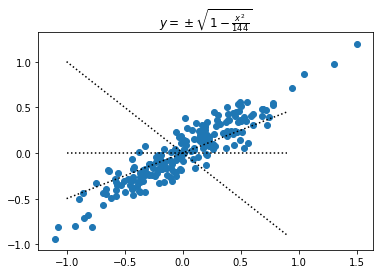

In [53]:
from mltoolbox.data.random import noisy_2d_func


angle = np.pi / 5
stretch = 5
m = 200

X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

xrange = np.arange(-1, 1, .1)
plt.scatter(X[:, 0], X[:, 1])
plt.plot(xrange, xrange*.5,'k:')
plt.plot(xrange, -xrange,'k:')
plt.plot(xrange, xrange*0,'k:') # optimal projection out of the 3
plt.title(r"$y=\pm \sqrt{1 - \frac{x^2}{144}}$")

Here, we have a 2 dimensional elipse. The dotted lines here represent a few possible "hyperplanes" that the data can be projected on. Let show these three various projections.

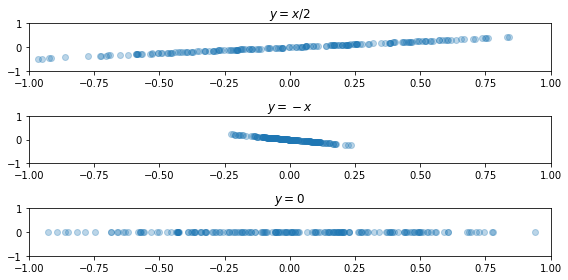

In [54]:
def proj(a, b):
    return (a@b / (np.linalg.norm(b) ** 2)) * b.reshape(-1, 1)

# note - that I am using an arbitrary point (0th element) as the vector for b to project to.
#        this really does not matter, since it going to be rescaled to the unit vector in the end.
#        what does matter however is that this point lies along the vector b and is nonzero.
a1, b1 = X, np.array([(xrange)[0], (xrange*.5)[0]])
a2, b2 = X, np.array([(xrange)[0], (-xrange)[0]])
a3, b3 = X, np.array([(xrange)[0], (xrange*0)[0]])

proj_X1 = proj(a1, b1)
proj_X2 = proj(a2, b2)
proj_X3 = proj(a3, b3)

fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(311)
plt.title(r'$y=x/2$')
plt.scatter(proj_X1[0, :], proj_X1[1, :], alpha=.3)
plt.axis([-1, 1, -1, 1])

ax = plt.subplot(312)
plt.title(r'$y=-x$')
plt.scatter(proj_X2[0, :], proj_X2[1, :], alpha=.3)
plt.axis([-1, 1, -1, 1])

ax = plt.subplot(313)
plt.title(r'$y=0$')
plt.scatter(proj_X3[0, :], proj_X3[1, :], alpha=.3)
plt.axis([-1, 1, -1, 1])
plt.tight_layout()

As we can see, the projection to hyper place $y=-x$ is the least optimal because the low variance hides the most information, where as $y=x/2$ doesn't preserves the most information because of it's high variance.

Otherway of thinking about it is that selecting that axis with the most variance minimizes the MSE between the dataset and the projection to the axis.

In [55]:
var1, var2, var3 = np.var(proj_X1[0, :]), np.var(proj_X2[0, :]), \
                   np.var(proj_X3[0, :])
print('y=x/2', 'var=', var1)
print('y=-x', 'var=', var2)
print('y=0', 'var=', var3)

y=x/2 var= 0.22358925318025946
y=-x var= 0.008171483899193272
y=0 var= 0.1885862324534333


As we have done before, PCA identifies the axis that accounts for the largest variance in the data. Then it identifies an axis orthogonal to this that accounts for the second largest variance. This same process is repeated on each previous axis until all the dimensions are exhausted in the dataset.

In PCA we identify these dimensions as principles components. These components are unit vectors in the axis that the data is projected onto. We use unit vectors because they are sufficient enough in describing the axis as a whole because any scale on say axis defines it as well. Secondly, the principle components are order such as way that the first component explains for the most amount of information, and the second component is orthogonal to the first and explains the second most amount of information.

## PCA Under the Hood

As another for complicated _example_, suppose we wanted to find the reduce the dimensionality of this parametric curve. Following through this example, we will walk through how sklearn approaches this question, and how we can follow through it ourselves.

No handles with labels found to put in legend.


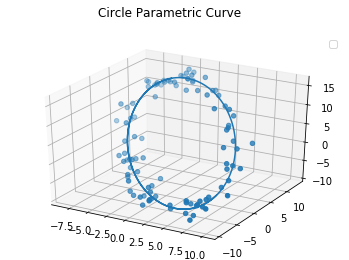

In [56]:
from mltoolbox.draw.math import plt_3d_parametric
from mltoolbox.data.random import noisy_3d_parametric


t = np.arange(-5, 5, .05)
x, y, z = lambda t: 1 + 4*np.cos(t) + 7*-np.sin(t), \
          lambda t: 2 + 5*np.cos(t) + 8*np.sin(t), \
          lambda t: 3 + 6*np.cos(t) + 9*np.sin(t)
ax = plt_3d_parametric([[x, y, z]], t, suptitle='Circle Parametric Curve')

x_n, y_n, z_n = noisy_3d_parametric([x, y, z], t, 100, (1,1,1))
ax.scatter(x_n, y_n, z_n)

Now just like selecting an angle with a camera and taking a snap shot, we can project the plane that outlines circle, and remove one of the dimensions.

**PCA Projection via SKlearn**

In [57]:
from sklearn.decomposition import PCA


X = np.c_[x_n, y_n, z_n]
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# we can also individual access the components like this
# pca.components_.T[:, <nth component>]

# we can also look into the ratio of variance that
# is explained by each component to the dataset
print('Explained variances, all components')
pca.explained_variance_ratio_

Explained variances, all components


array([0.84434634, 0.14823685])

In our case, 83% of all variance in the dataset is captures in the first dimension and 15% is the second dimension. In total our visualization accounts for only a 3% loss of information as measured by variance.

Text(0, 0.5, '$x_2$')

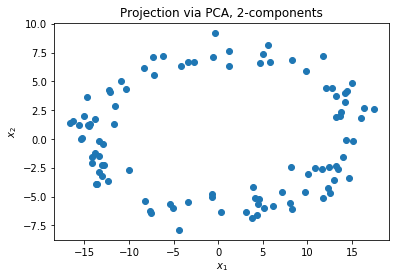

In [58]:
plt.scatter(X2D[:, 0], X2D[:, 1])
plt.title('Projection via PCA, 2-components')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

**PCA Manually**

So what happens under the hood? How does this module know what dimensions to take, and which to depricate?

There is a standard matrix factorization technique known as SVD or Singular Value Decompsition. You can read about more ![here](link to svd).

SVD decomposition an input matrix into three matricies $U \sum and V^T$. $V$ will contain all the principle components we are interested in. The idea is that we can take these principle components from Vt and reintroduce a d dimensions that ensure most of the variance is preserved in these d dimensions.

Text(0, 0.5, '$x_2$')

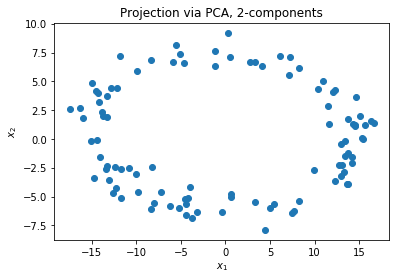

In [59]:
# remove the mean of each colomn, centering X around 0
# this is an assumption made by PCA
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
m, n = X.shape

# extract out the first two principle components from V
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

plt.scatter(X2D[:, 0], X2D[:, 1])
plt.title('Projection via PCA, 2-components')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

As we have done before, PCA identifies the axis that accounts for the largest variance in the data. Then it identifies an axis orthogonal to this that accounts for the second largest variance. This same process is repeated on each previous axis until all the dimensions are exhausted in the dataset.

In PCA we identify these dimensions as principles components. These components are unit vectors in the axis that the data is projected onto. We use unit vectors because they are sufficient enough in describing the axis as a whole because any scale on say axis defines it as well. Secondly, the principle components are order such as way that the first component explains for the most amount of information, and the second component is orthogonal to the first and explains the second most amount of information.

## Identifing the Optimal Number of Components Or Dimensions

Suppose that rather than for the purposes of data visualization (in which case we would use the first 2-3 components), we were interested in finding the number of components for optimal performance from the model.

### Approach 1

The following method demonstrates a brute force technique that achieves this.

In [60]:
import progressbar
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.svm import SVC


dataset = load_digits()
X, y = dataset.data, dataset.target

base_c = SVC(gamma=0.005)
base_cv = cross_val_score(base_c, X, y, cv=4).mean()

opt_scores = []
bar = progressbar.ProgressBar()
for n in bar(range(5, X.shape[1]-5)):
    pca = PCA(n_components=n)
    X_n_kept = pca.fit_transform(X)
    classifier = SVC(gamma=0.005)
    score = cross_val_score(classifier, X_n_kept, y, cv=4).mean()
    opt_scores.append({'cv_score':score, 'pca_n_components': n})

opt_scores_df = pd.DataFrame(opt_scores)

100% (54 of 54) |########################| Elapsed Time: 0:00:39 Time:  0:00:39


Text(0.5, 1.0, 'CV Score by Principle Components')

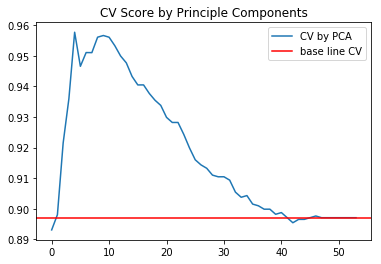

In [61]:
plt.plot(list(opt_scores_df.index), opt_scores_df['cv_score'], label='CV by PCA')
plt.axhline(y=base_cv, color='r', linestyle='-', label='base line CV')
plt.legend()
plt.title('CV Score by Principle Components')

In the above example, we can see how in the digits dataset in particular, running PCA proves useful. Another observation is the bell shape curve, which suggests that there an optimal principle component. 

### Approach 2

A more efficient technique would be to keep all the components by default, and then retraining PCA using the number of components that explain the variability of data by x%.

This exact process can be specified implicitly by setting the `n_components` to a floating point number between 0 and 1. Where `n_components` specifies the ratio of variance that is to be preserved.

In [62]:
pca = PCA()
pca.fit(X)

# stack the components on top of one another, and see
# how each dimension independently stacks variance
cumsum = np.cumsum(pca.explained_variance_ratio_)

# select the index (+1) that first identifies >= 95% 
# of variance explained
d = np.argmax(cumsum >= 0.80) + 1
pca = PCA(n_components=d)
X_new = pca.fit_transform(X)
c = SVC(gamma=0.005)
cv_new = cross_val_score(classifier, X_new, y, cv=4).mean()
print('manually:\n\t', 'n_components:', d, 'cv_score', cv_new)

pca = PCA(n_components=.90)
X_new = pca.fit_transform(X)
c = SVC(gamma=0.005)
cv_new = cross_val_score(classifier, X_new, y, cv=4).mean()
print('automatically:\n\t', 'n_components:', pca.n_components, 'cv_score', cv_new)

manually:
	 n_components: 13 cv_score 0.9560724496669081
automatically:
	 n_components: 0.9 cv_score 0.9404852540110145


This might still beg the question, what do I select as cummulative variability? One way to base this is to select a point in the cumulative summation where adding an additional dimension does not add much. The cumulative summative curve generally has a distinct shape where the first few components make up a majority of the explained variance and the last few components measure a disproportionatly smaller explained variance.

Text(0.5, 1.0, 'A Reasonable Stopping Point for the Selection on the Number of Dimensions')

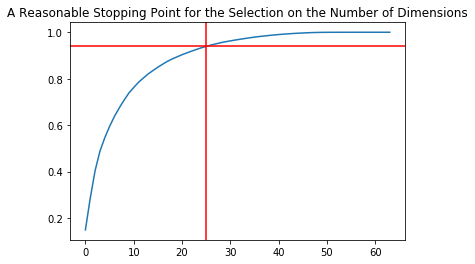

In [63]:
plt.plot(cumsum)
plt.axhline(y=.94, color='r', linestyle='-')
plt.axvline(x=25, color='r', linestyle='-')
plt.title("A Reasonable Stopping Point for the Selection on the Number of Dimensions")

We can think of `d=25` here as the intrinsic dimensionality for the digits dataset.

## PCA for Compression

One obvious benefit of PCA is that reducing the dimensionality of the dataset makes it physically smaller, as the expense small information loss. As a result, training time is reduced by a large amount.

It is also possible to decompress the data by applying the inverse transformation, reprojecting back the original dataset to the original dimension space ($X_{rec} = X_{d-proj}W_d^T$). This process is not lossless since there was information loss as a result of the original projection. 

The MSE from the original dataset to the restructed dataset is known as _reconstruction error_.

In [64]:
pca = PCA(n_components = 24)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Recovered Samples')

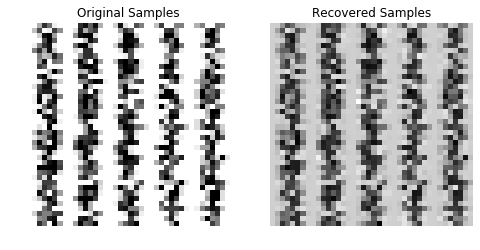

In [65]:
import matplotlib as mpl


def plot_digits(instances, im_per_c=5, im_per_r=5, single_im_dim=(8, 8)):
    n_images = im_per_c*im_per_r
    inst_as_im = [inst.reshape(single_im_dim) for inst in instances]
    inst_as_im = np.array(inst_as_im[:n_images])
    plt.imshow(np.reshape(inst_as_im, (im_per_r*single_im_dim[0], im_per_c*single_im_dim[1])), cmap=mpl.cm.binary)
    plt.axis("off")


plt.figure(figsize=(8, 5))
plt.subplot(121)
plot_digits(X, 5, 5)
plt.title('Original Samples')

plt.subplot(122)
plot_digits(X_recovered, 5, 5)
plt.title('Recovered Samples')

## Incremental PCA

Previously, in order to perform an PCA we used svd decomposition, which requires the entire training set to fit into memory. In cases when this is not possible, we employ IPCA, or _Incremental PCA_, which feeds the training data as minibatches into the algorithm.

Incremental PCA is also useful for online learning, where adding new information can be used to update the model on the fly as instances arrive. 


In [66]:
from sklearn.decomposition import IncrementalPCA


n_batches = 10
inc_pca = IncrementalPCA(n_components=25)

# split into batchs or chunks
# notice the use of partial fit
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X)

## Randomized PCA

PCA also employs a stochastic training technique that _approximates_ the top _d_ components. The stochastic approach is expected to run in $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$, so its on significant smaller order of computational complexity.


In [67]:
rnd_pca = PCA(n_components=24, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)

## Kernal PCA (kPCA)

Recall how support vector machines were able to make a linear classifications using the kernal trick by mapping each instance into a higher dimensional space. Taking this same idea, we can use PCA to make nonlinear projections rather than projecting it to a specific axis or line in space as we have been doing before.

kPCA is particularly good at preserving clusters of information, and sometimes also combating twisted manifolds.

In [68]:
from sklearn.decomposition import KernelPCA


rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

A simple integrated model pipeline might look something like this

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


clf = Pipeline([
        ("kpca", KernelPCA(n_components=24)),
        ("rfc", RandomForestClassifier())
    ])

param_grid = [{
        "rfc__n_estimators": [100, 200],
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
grid_search.best_params_

{'kpca__kernel': 'rbf', 'rfc__n_estimators': 200}